source: https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac#63b2
source: https://stackoverflow.com/questions/37228371/visualize-mnist-dataset-using-opencv-or-matplotlib-pyplot

color source: https://matplotlib.org/stable/tutorials/colors/colors.html
palette source: https://seaborn.pydata.org/tutorial/color_palettes.html

In [16]:
# imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import random
import tqdm
import time

from permutation_testing import *
from model import *

plt.rcParams['patch.edgecolor'] = 'none'


In [2]:
# setting random seed
# https://pytorch.org/docs/stable/notes/randomness.html 
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True

torch.backends.cudnn.benchmark = False 

In [3]:
%load_ext autoreload
%autoreload 2

torch.Size([256, 1, 28, 28])
Number of training samples: 60000
Number of test samples: 10000


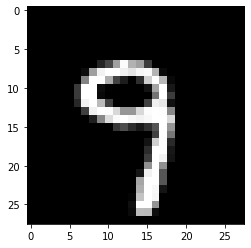

In [4]:
# create train/valid/test splits; set batch size

data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.ToTensor(),])
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m = len(train_dataset)
batch_size = 256

train_data, val_data = random_split(train_dataset, [int(0.8 * m), int(0.2 * m)])
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False) # dangit

for data in train_loader:
    print(data[0].shape)
    break

plt.imshow(data[0][0].squeeze(), cmap='gray')

print('Number of training samples:', len(train_dataset))
print('Number of test samples:', len(test_dataset))

### keeping track of model weights
- 05232023a: epochs=50, lr=1e-3, d=4, inplace=T, ReLU
- 05302023a: epochs=50, lr=1e-3, d=4, inplace=F, ReLU 
- 05302023b: epochs=50, lr=1e-3, d=4, inplace=F, ELU 
- 06072023a: epochs=50, lr=1e-3, d=4, inplace=F, ELU; used deterministic things from PyTorch
    - epoch 50: train loss: 0.02580, val loss: 0.02636
- 06072023b: epochs=50, lr=1e-3, d=4, inplace=F, ELU; additionally used `torch.backends.cudnn.benchmark = False`
    - epoch 50: train loss: 0.02580, val loss: 0.02636
- 06072023c: same settings as 06072023b except d=6
    - epoch 50: train loss: 0.01868, val loss: 0.01931


In [5]:
# set certain hyperparameters
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')  

loss_fn = torch.nn.MSELoss()
lr = 0.001
num_epochs = 50
d = 6

Selected device: cpu


In [7]:
%%time
# train/load models

train = False
version = '06072023c' # NOTE: MAKE SURE TO UPDATE THIS EVERY TIME

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

if train: 
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]

    optimizer = optim.Adam(params_to_optimize, lr=lr)
    print_every = 10

    encoder.to(device)
    decoder.to(device)
    plot_ae_outputs(encoder, decoder, test_dataset, device, n=10)
    losses = {'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        train_loss = train_epoch(encoder,decoder,device, train_loader,loss_fn, optimizer)
        val_loss = test_epoch(encoder, decoder, device, val_loader, loss_fn) # better for this to be val_loader?
        print('EPOCH {}/{}: train loss: {:.5f}, val loss: {:.5f}'.format(epoch + 1, num_epochs, train_loss, val_loss))
        losses['train_loss'].append(train_loss)
        losses['val_loss'].append(val_loss)
        if (epoch + 1) % print_every == 0:
            plot_ae_outputs(encoder, decoder, test_dataset, device, n=10)
    # save the model
    torch.save(encoder.state_dict(), 'weights/encoder_weights_' + version + '.pth')
    torch.save(decoder.state_dict(), 'weights/decoder_weights_' + version + '.pth')
else:
    encoder.load_state_dict(torch.load('weights/encoder_weights_' + version + '.pth'))
    decoder.load_state_dict(torch.load('weights/decoder_weights_' + version + '.pth'))

encoder.eval(), decoder.eval()

CPU times: user 5.45 ms, sys: 4.21 ms, total: 9.66 ms
Wall time: 9.02 ms


(Encoder(
   (encoder_cnn): Sequential(
     (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (1): ELU(alpha=1.0)
     (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     (3): ELU(alpha=1.0)
     (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
     (5): ELU(alpha=1.0)
   )
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (encoder_lin): Sequential(
     (0): Linear(in_features=288, out_features=128, bias=True)
     (1): ELU(alpha=1.0)
     (2): Linear(in_features=128, out_features=6, bias=True)
   )
 ),
 Decoder(
   (decoder_lin): Sequential(
     (0): Linear(in_features=6, out_features=128, bias=True)
     (1): ELU(alpha=1.0)
     (2): Linear(in_features=128, out_features=288, bias=True)
     (3): ELU(alpha=1.0)
   )
   (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
   (decoder_conv): Sequential(
     (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
     (1): ELU(alpha=1.0)
     (2): ConvTranspose2d(16, 

In [8]:
test_error_on_classes = True
losses = {key.item(): value.item() for key, value in zip(data[1].unique(), torch.zeros(10))}
if test_error_on_classes:
    for label in data[1].unique():
        num_digits = 0
        for ind, data in enumerate(test_loader):
            idx = data[1] == label.item()
            num_digits += idx.sum().item()
            original_images = data[0][idx]
            recon_images = decoder(encoder(original_images))
            losses[label.item()] += loss_fn(original_images, recon_images).item()
        losses[label.item()] /= num_digits
        losses[label.item()] = np.round(losses[label.item()], 7)
pd.Series(losses).sort_values()

1    0.000144
7    0.000541
9    0.000646
4    0.000728
0    0.000733
6    0.000748
3    0.000971
2    0.001020
5    0.001158
8    0.001194
dtype: float64

## Convenience Functions

In [9]:
def p_val(simulated_stats, observed_stat):
    return (np.array([stat.item() for stat in simulated_stats]) > observed_stat.item()).mean()#i

In [10]:
def plot_permutation(
        simulated_stats, 
        observed_stat, 
        bins=50, 
        filepath='', 
        hist_color='tab:blue', 
        line_color='tab.red'
    ):
    print('p_value:', p_val(simulated_stats, observed_stat))
    sns.displot([mmd.item() for mmd in simulated_stats], bins=bins, color=hist_color)
    plt.axvline(observed_stat.item(), color=line_color)
    if filepath != '':
        print('Image saved to ' + str(filepath))
        plt.savefig(filepath + '.jpg', bbox_inches='tight')
    else:
        print('No image saved.')
    return

## Creating X and Y samples

### $X$ = {images of 5's}, $Y$ = {images of 8's}

In [11]:
x_batch = []
y_batch = []
for ind, data in enumerate(test_loader): # filter batches based on digit
    if ind == 3: 
        r_batch = data[0][(data[1] == 5) | (data[1] == 8)]
    elif 3 < ind and ind < 15:
        x_batch.append(data[0][data[1] == 5])
        y_batch.append(data[0][data[1] == 8])
    elif ind == 15: 
        break
x_batch = torch.cat(x_batch, dim=0)
y_batch = torch.cat(y_batch, dim=0)
print('x_batch shape:', x_batch.shape)
print('y_batch shape:', y_batch.shape)
print('r_batch shape:', r_batch.shape)

n_perms = 250

x_batch shape: torch.Size([264, 1, 28, 28])
y_batch shape: torch.Size([277, 1, 28, 28])
r_batch shape: torch.Size([43, 1, 28, 28])


In [12]:
xy_batch = torch.cat([x_batch, y_batch], dim=0)
xy_batch_sample_mean = xy_batch.squeeze().flatten(start_dim=1).mean(dim=0)
xy_batch_sample_var = ((xy_batch.squeeze().flatten(start_dim=1) - xy_batch_sample_mean) ** 2).sum() 
xy_batch_sample_var /= (len(xy_batch ) - 1)
xy_batch_sample_var = xy_batch_sample_var.item()
print('xy_batch sample variance:', xy_batch_sample_var)

num_features = 28 * 28
print('number of features:', num_features)

scale_sigma_squared = 1 / (xy_batch_sample_var * num_features)
auto_sigma_squared = 1 / num_features
print('bandwidth selected by sklearn\'s scale method:', scale_sigma_squared)
print('bandwidth selected by sklearn\'s auto method:', auto_sigma_squared)

xy_batch sample variance: 46.81251907348633
number of features: 784
bandwidth selected by sklearn's scale method: 2.7247202870653804e-05
bandwidth selected by sklearn's auto method: 0.0012755102040816326


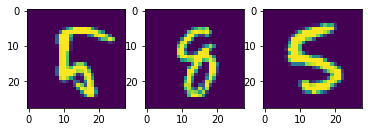

In [13]:
plt.subplot(1,3,1)
plt.imshow(x_batch[0].squeeze())
plt.subplot(1,3,2)
plt.imshow(y_batch[0].squeeze())
plt.subplot(1,3,3)
plt.imshow(r_batch[0].squeeze())

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Statistics for Anisotropic Kernel

trial: 1


100%|██████████| 250/250 [00:17<00:00, 13.91it/s]


bandwidth: 0.125
p_value: 0.0
No image saved.


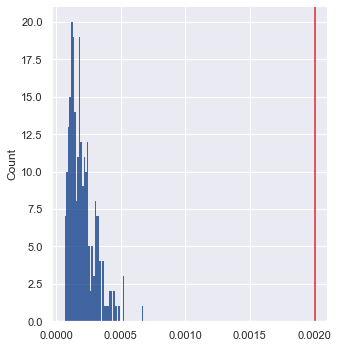

trial: 2


100%|██████████| 250/250 [00:17<00:00, 14.15it/s]


bandwidth: 0.125
p_value: 0.0
No image saved.


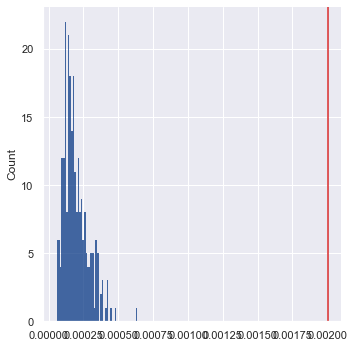

trial: 3


100%|██████████| 250/250 [00:17<00:00, 14.33it/s]


bandwidth: 0.125
p_value: 0.0
No image saved.


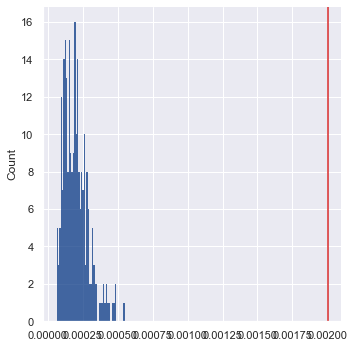

trial: 1


100%|██████████| 250/250 [00:18<00:00, 13.79it/s]


bandwidth: 0.25
p_value: 0.0
No image saved.


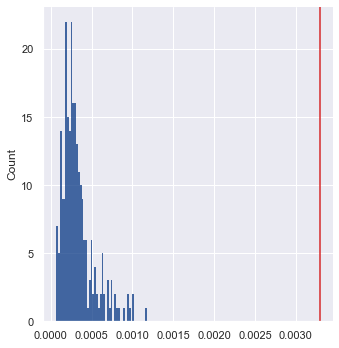

trial: 2


100%|██████████| 250/250 [00:17<00:00, 14.38it/s]


bandwidth: 0.25
p_value: 0.0
No image saved.


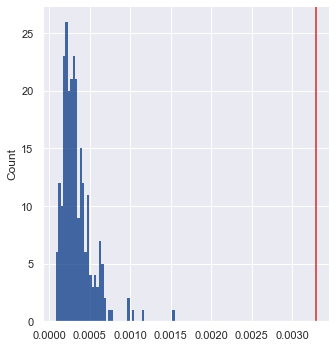

trial: 3


100%|██████████| 250/250 [00:15<00:00, 16.27it/s]


bandwidth: 0.25
p_value: 0.0
No image saved.


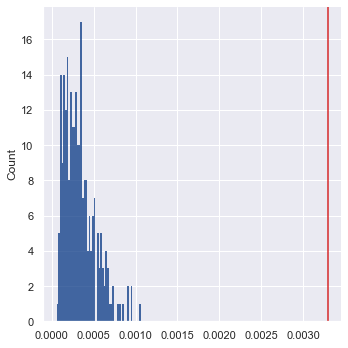

trial: 1


100%|██████████| 250/250 [00:16<00:00, 14.93it/s]


bandwidth: 0.5
p_value: 0.0
No image saved.


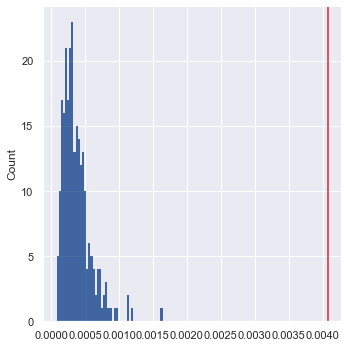

trial: 2


100%|██████████| 250/250 [00:17<00:00, 14.60it/s]


bandwidth: 0.5
p_value: 0.0
No image saved.


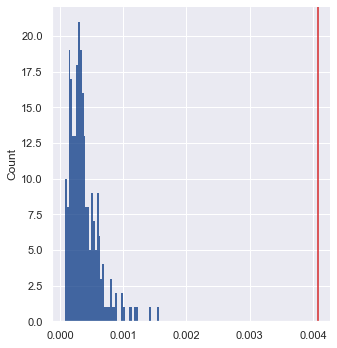

trial: 3


100%|██████████| 250/250 [00:16<00:00, 14.73it/s]


bandwidth: 0.5
p_value: 0.0
No image saved.


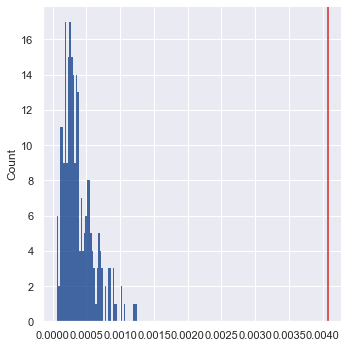

trial: 1


100%|██████████| 250/250 [00:17<00:00, 14.42it/s]


bandwidth: 1
p_value: 0.0
No image saved.


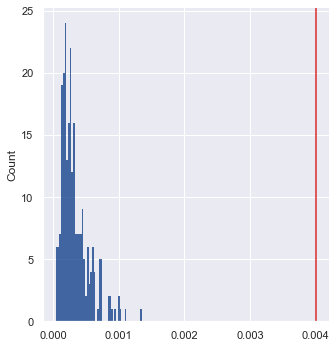

trial: 2


100%|██████████| 250/250 [00:17<00:00, 14.43it/s]


bandwidth: 1
p_value: 0.0
No image saved.


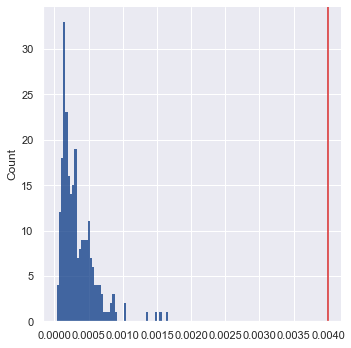

trial: 3


100%|██████████| 250/250 [00:15<00:00, 16.33it/s]


bandwidth: 1
p_value: 0.0
No image saved.


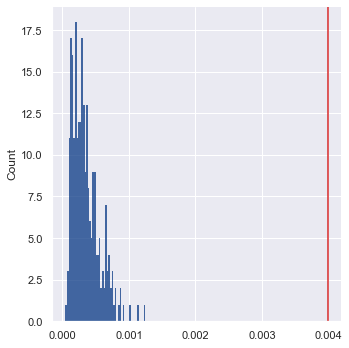

trial: 1


100%|██████████| 250/250 [00:15<00:00, 15.75it/s]


bandwidth: 2
p_value: 0.0
No image saved.


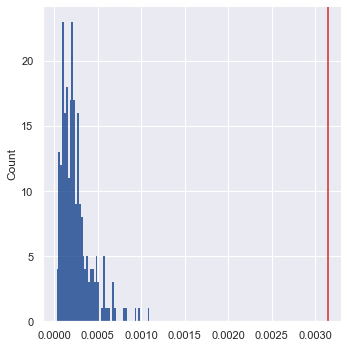

trial: 2


100%|██████████| 250/250 [00:15<00:00, 15.88it/s]


bandwidth: 2
p_value: 0.0
No image saved.


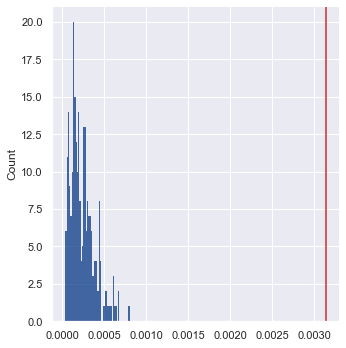

trial: 3


100%|██████████| 250/250 [00:15<00:00, 16.28it/s]


bandwidth: 2
p_value: 0.0
No image saved.


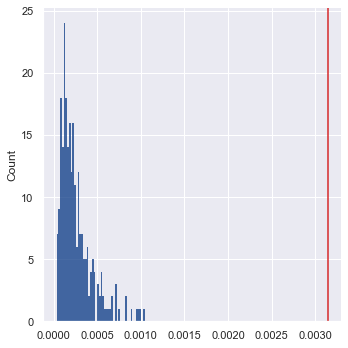

trial: 1


100%|██████████| 250/250 [00:15<00:00, 15.86it/s]


bandwidth: 4
p_value: 0.0
No image saved.


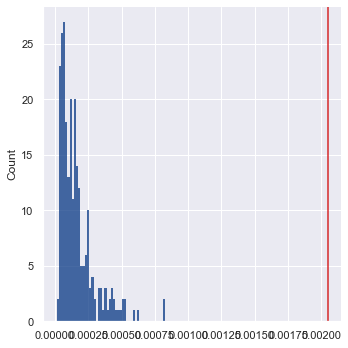

trial: 2


100%|██████████| 250/250 [00:17<00:00, 14.34it/s]


bandwidth: 4
p_value: 0.0
No image saved.


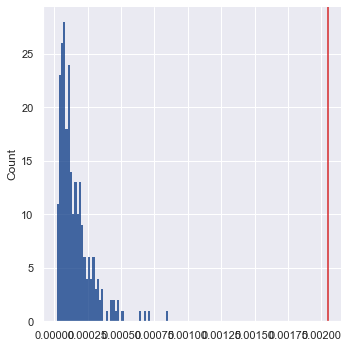

trial: 3


100%|██████████| 250/250 [00:17<00:00, 14.69it/s]


bandwidth: 4
p_value: 0.0
No image saved.


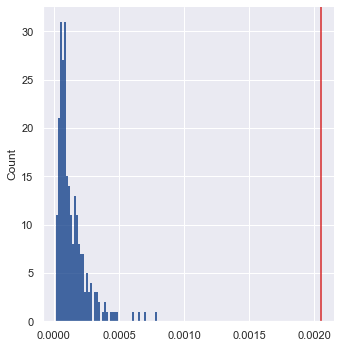

trial: 1


100%|██████████| 250/250 [00:16<00:00, 14.97it/s]


bandwidth: 8
p_value: 0.0
No image saved.


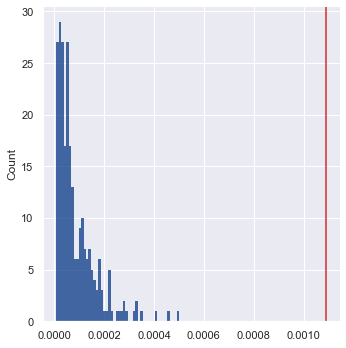

trial: 2


100%|██████████| 250/250 [00:17<00:00, 14.50it/s]


bandwidth: 8
p_value: 0.0
No image saved.


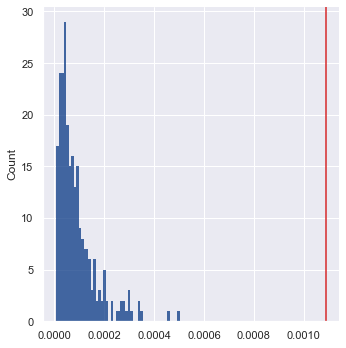

trial: 3


100%|██████████| 250/250 [00:16<00:00, 14.86it/s]


bandwidth: 8
p_value: 0.0
No image saved.


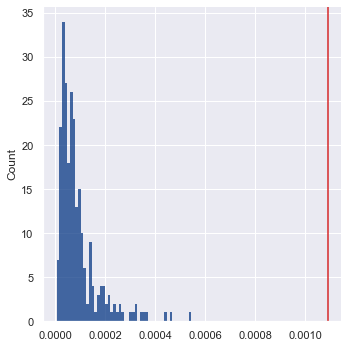

CPU times: user 8min 18s, sys: 20min 17s, total: 28min 35s
Wall time: 6min 17s


In [19]:
%%time

# anisotropic mmd

num_trials = 3
encoder.eval()
diff_anisotropic_stats = {}
for val in [-3, -2, -1, 0, 1, 2, 3]:
    diff_anisotropic_stats[val] = {}
    for trial in range(1, num_trials + 1):
        print('trial:', trial)
        start = time.time()
        observed_mmd_anisotropic8v5, simulated_mmds_anisotropic8v5 = permutation_test_anisotropic_mmd(
            x_batch, y_batch, r_batch, encoder, n_perms=n_perms, sigma_squared=(2 ** val)
        )
        end = time.time()
        p = p_val(simulated_mmds_anisotropic8v5, observed_mmd_anisotropic8v5)
        diff_anisotropic_stats[val][trial] = {'p': p, 'time': end - start}

        hist_color = '#093885'
        line_color = 'tab:red'
        filepath = ''

        print('bandwidth:', str(np.round(2 ** val, 3)))
        plot_permutation(
            simulated_mmds_anisotropic8v5, 
            observed_mmd_anisotropic8v5, 
            hist_color = hist_color, 
            line_color = line_color,
            filepath = filepath
        )
        plt.show()

In [21]:
diff_anisotropic_stats

{-3: {1: {'p': 0.0, 'time': 19.655205249786377},
  2: {'p': 0.0, 'time': 18.616301774978638},
  3: {'p': 0.0, 'time': 18.53248620033264}},
 -2: {1: {'p': 0.0, 'time': 19.132415056228638},
  2: {'p': 0.0, 'time': 18.63259792327881},
  3: {'p': 0.0, 'time': 16.26215624809265}},
 -1: {1: {'p': 0.0, 'time': 18.031315088272095},
  2: {'p': 0.0, 'time': 17.925496816635132},
  3: {'p': 0.0, 'time': 18.262054204940796}},
 0: {1: {'p': 0.0, 'time': 18.339603900909424},
  2: {'p': 0.0, 'time': 18.61233401298523},
  3: {'p': 0.0, 'time': 16.253310918807983}},
 1: {1: {'p': 0.0, 'time': 17.1073637008667},
  2: {'p': 0.0, 'time': 16.624356746673584},
  3: {'p': 0.0, 'time': 16.324429035186768}},
 2: {1: {'p': 0.0, 'time': 16.67528009414673},
  2: {'p': 0.0, 'time': 18.57192873954773},
  3: {'p': 0.0, 'time': 17.906415939331055}},
 3: {1: {'p': 0.0, 'time': 17.455366849899292},
  2: {'p': 0.0, 'time': 18.29229712486267},
  3: {'p': 0.0, 'time': 17.72061014175415}}}

### Statistics for Encoder Kernel

100%|██████████| 250/250 [00:33<00:00,  7.40it/s]


bandwidth: 0.125
p_value: 0.312
No image saved.


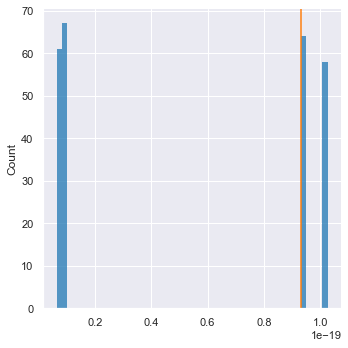

100%|██████████| 250/250 [00:35<00:00,  7.05it/s]


bandwidth: 0.125
p_value: 0.376
No image saved.


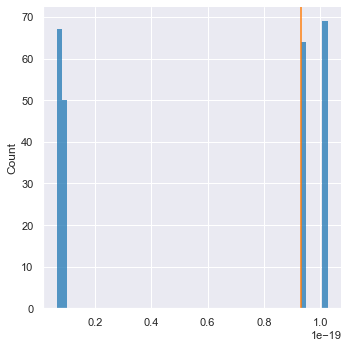

100%|██████████| 250/250 [00:34<00:00,  7.35it/s]


bandwidth: 0.125
p_value: 0.328
No image saved.


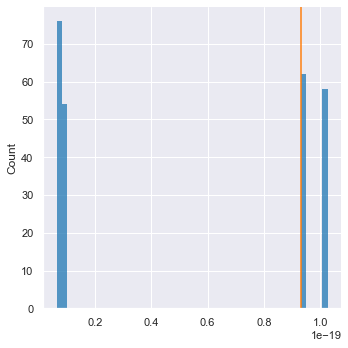

100%|██████████| 250/250 [00:57<00:00,  4.37it/s]


bandwidth: 0.25
p_value: 0.324
No image saved.


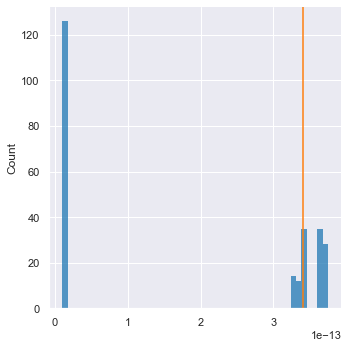

100%|██████████| 250/250 [00:34<00:00,  7.20it/s]


bandwidth: 0.25
p_value: 0.272
No image saved.


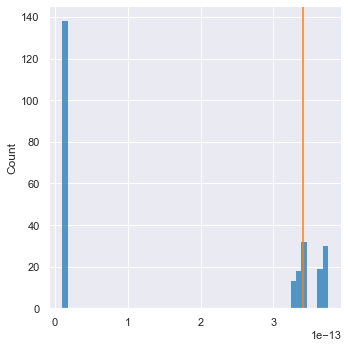

100%|██████████| 250/250 [00:32<00:00,  7.59it/s]


bandwidth: 0.25
p_value: 0.332
No image saved.


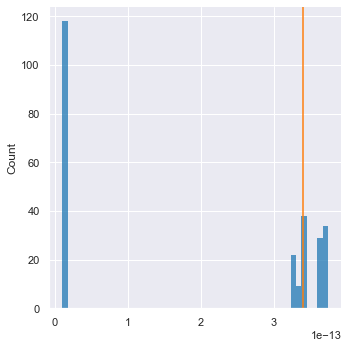

100%|██████████| 250/250 [00:31<00:00,  8.04it/s]


bandwidth: 0.5
p_value: 0.156
No image saved.


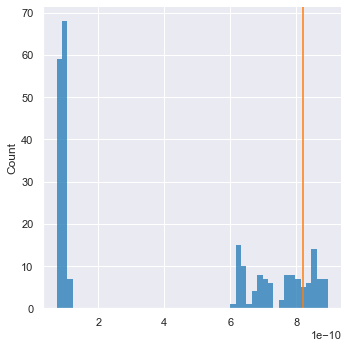

100%|██████████| 250/250 [00:32<00:00,  7.77it/s]


bandwidth: 0.5
p_value: 0.132
No image saved.


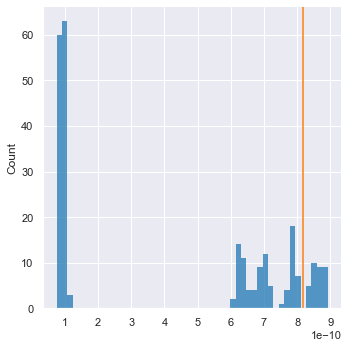

100%|██████████| 250/250 [00:31<00:00,  8.05it/s]


bandwidth: 0.5
p_value: 0.12
No image saved.


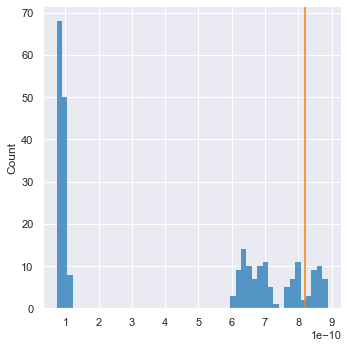

100%|██████████| 250/250 [00:30<00:00,  8.08it/s]


bandwidth: 1
p_value: 0.0
No image saved.


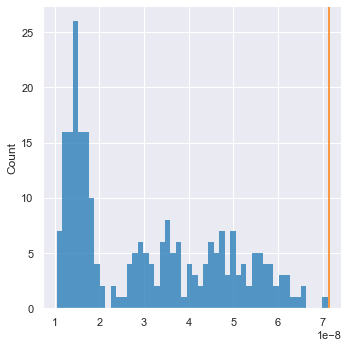

100%|██████████| 250/250 [00:32<00:00,  7.76it/s]


bandwidth: 1
p_value: 0.0
No image saved.


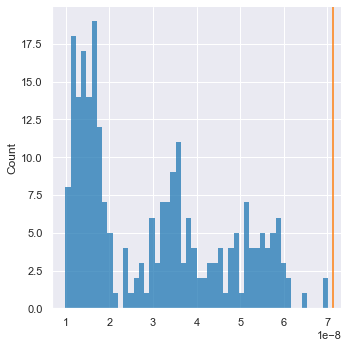

100%|██████████| 250/250 [00:32<00:00,  7.62it/s]


bandwidth: 1
p_value: 0.0
No image saved.


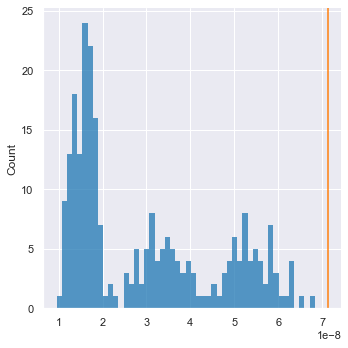

100%|██████████| 250/250 [00:30<00:00,  8.27it/s]


bandwidth: 2
p_value: 0.0
No image saved.


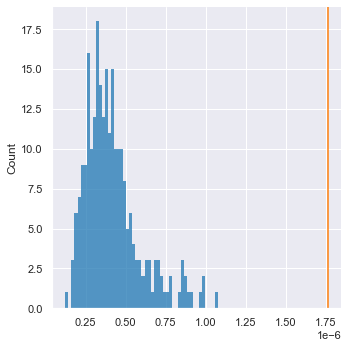

100%|██████████| 250/250 [00:30<00:00,  8.07it/s]


bandwidth: 2
p_value: 0.0
No image saved.


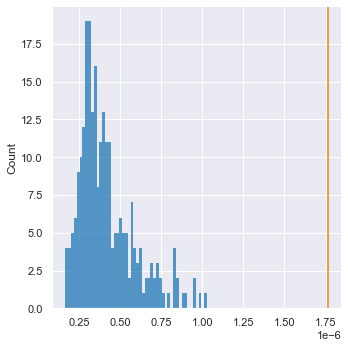

100%|██████████| 250/250 [00:33<00:00,  7.54it/s]


bandwidth: 2
p_value: 0.0
No image saved.


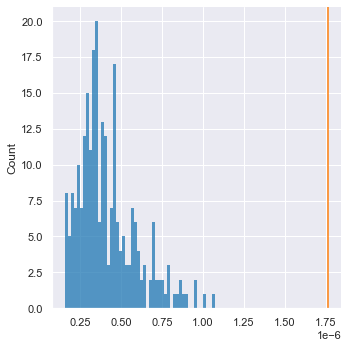

100%|██████████| 250/250 [00:33<00:00,  7.51it/s]


bandwidth: 4
p_value: 0.0
No image saved.


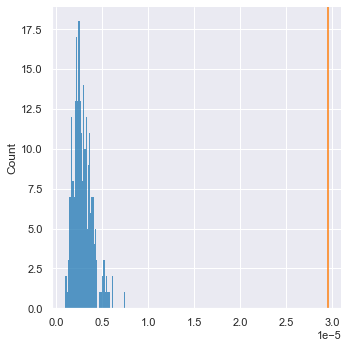

100%|██████████| 250/250 [00:32<00:00,  7.61it/s]


bandwidth: 4
p_value: 0.0
No image saved.


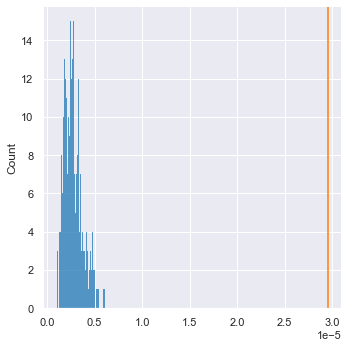

100%|██████████| 250/250 [00:33<00:00,  7.37it/s]


bandwidth: 4
p_value: 0.0
No image saved.


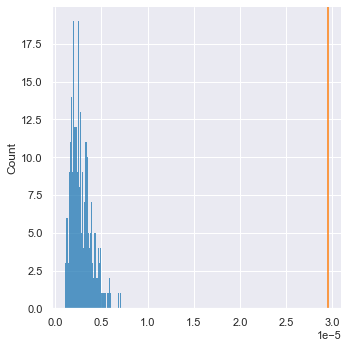

100%|██████████| 250/250 [00:30<00:00,  8.08it/s]


bandwidth: 8
p_value: 0.0
No image saved.


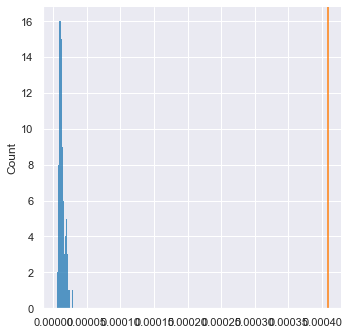

100%|██████████| 250/250 [00:30<00:00,  8.06it/s]


bandwidth: 8
p_value: 0.0
No image saved.


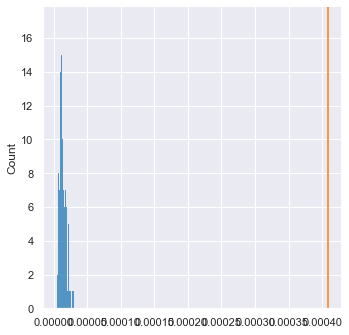

100%|██████████| 250/250 [00:34<00:00,  7.22it/s]


bandwidth: 8
p_value: 0.0
No image saved.


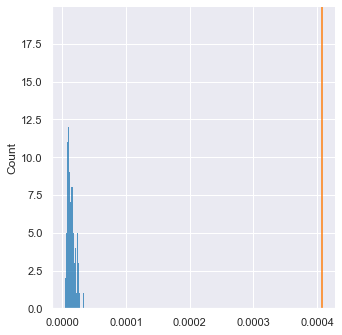

CPU times: user 14min 51s, sys: 38min 55s, total: 53min 47s
Wall time: 13min 8s


In [22]:
%%time

# encoder mmd

num_trials = 3
encoder.eval()
diff_encoder_stats = {}
for val in [-3, -2, -1, 0, 1, 2, 3]:
    diff_encoder_stats[val] = {}
    for trial in range(1, num_trials + 1):
        print('trial:', trial)
        start = time.time()
        observed_mmd_encoder8v5, simulated_mmds_encoder8v5 = permutation_test_encoder_mmd(
            x_batch, y_batch, r_batch, encoder, n_perms=n_perms, sigma_squared=(2 ** val)
        )
        end = time.time()
        p = p_val(simulated_mmds_encoder8v5, observed_mmd_encoder8v5)
        diff_encoder_stats[val][trial] = {'p': p, 'time': end - start}

        hist_color = 'tab:blue'
        line_color = 'tab:orange'
        filepath = ''

        print('bandwidth:', str(np.round(2 ** val, 3)))
        plot_permutation(
            simulated_mmds_encoder8v5, 
            observed_mmd_encoder8v5, 
            hist_color = hist_color, 
            line_color = line_color,
            filepath = filepath
        )
        plt.show()

In [23]:
diff_encoder_stats

{-3: {1: {'p': 0.312, 'time': 33.94242787361145},
  2: {'p': 0.376, 'time': 39.29855298995972},
  3: {'p': 0.328, 'time': 37.18475389480591}},
 -2: {1: {'p': 0.324, 'time': 60.61105823516846},
  2: {'p': 0.272, 'time': 38.61434316635132},
  3: {'p': 0.332, 'time': 36.8093159198761}},
 -1: {1: {'p': 0.156, 'time': 34.896141052246094},
  2: {'p': 0.132, 'time': 35.97610425949097},
  3: {'p': 0.12, 'time': 34.85029578208923}},
 0: {1: {'p': 0.0, 'time': 34.74777412414551},
  2: {'p': 0.0, 'time': 36.013132095336914},
  3: {'p': 0.0, 'time': 36.618114709854126}},
 1: {1: {'p': 0.0, 'time': 34.07421517372131},
  2: {'p': 0.0, 'time': 34.70034098625183},
  3: {'p': 0.0, 'time': 36.88516402244568}},
 2: {1: {'p': 0.0, 'time': 37.298651695251465},
  2: {'p': 0.0, 'time': 37.05825209617615},
  3: {'p': 0.0, 'time': 38.035945892333984}},
 3: {1: {'p': 0.0, 'time': 34.933125019073486},
  2: {'p': 0.0, 'time': 34.99283480644226},
  3: {'p': 0.0, 'time': 38.47118592262268}}}

### $X_1$ = {images of 5's}, $X_2$ = {images of 5's}

In [24]:
# testing when x_batch and y_batch are from the same distribution
x1_batch = []
x2_batch = []
r_batch = []
for ind, data in enumerate(test_loader): # filter batches based on digit
    if ind < 3:
        r_batch.append(data[0][data[1] == 5])
    elif 3 <= ind and ind % 2 == 0:
        x1_batch.append(data[0][data[1] == 5])
    elif 3 <= ind and ind % 2 == 1:
        x2_batch.append(data[0][data[1] == 5])
    if ind == 25: break
x1_batch = torch.cat(x1_batch, dim=0)
x2_batch = torch.cat(x2_batch, dim=0)
r_batch = torch.cat(r_batch, dim=0)
print('x1_batch shape:', x1_batch.shape)
print('x2_batch shape:', x2_batch.shape)
print('r_batch shape:', r_batch.shape)

x1_batch shape: torch.Size([263, 1, 28, 28])
x2_batch shape: torch.Size([273, 1, 28, 28])
r_batch shape: torch.Size([70, 1, 28, 28])


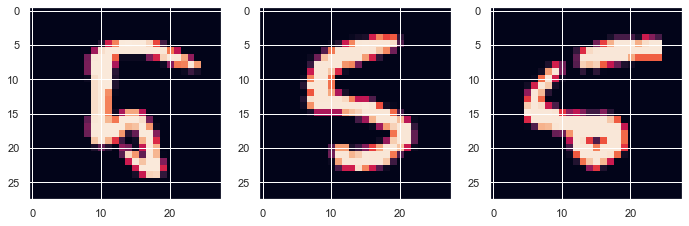

In [25]:
plt.subplot(1,3,1)
plt.imshow(x1_batch[0].squeeze())
plt.subplot(1,3,2)
plt.imshow(x2_batch[0].squeeze())
plt.subplot(1,3,3)
plt.imshow(r_batch[0].squeeze())

### Statistics for Anisotropic Kernel

trial: 1


100%|██████████| 250/250 [00:18<00:00, 13.80it/s]


bandwidth: 0.125
p_value: 0.328
No image saved.


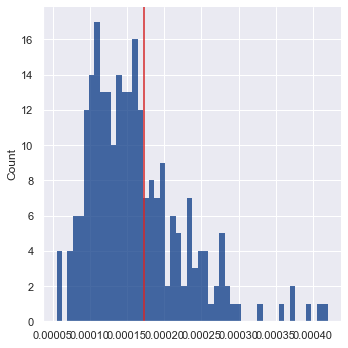

trial: 2


100%|██████████| 250/250 [00:16<00:00, 14.89it/s]


bandwidth: 0.125
p_value: 0.328
No image saved.


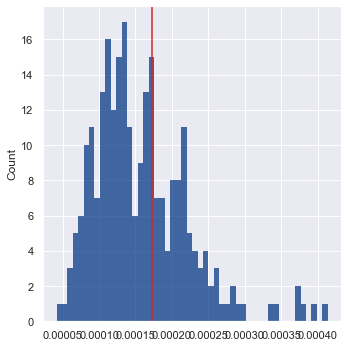

trial: 3


100%|██████████| 250/250 [00:18<00:00, 13.63it/s]

bandwidth: 0.125
p_value: 0.328
No image saved.


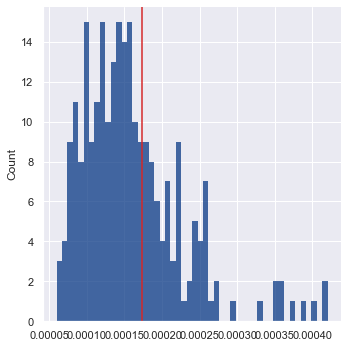

trial: 1


100%|██████████| 250/250 [00:17<00:00, 14.52it/s]


bandwidth: 0.25
p_value: 0.488
No image saved.


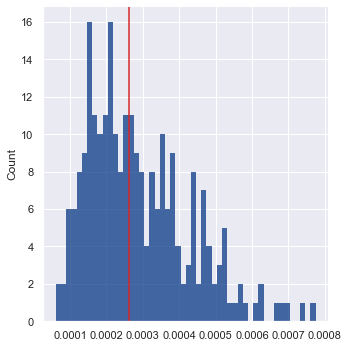

trial: 2


100%|██████████| 250/250 [00:17<00:00, 14.06it/s]


bandwidth: 0.25
p_value: 0.5
No image saved.


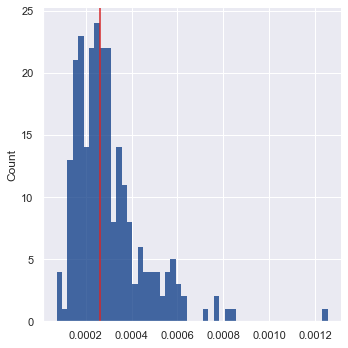

trial: 3


100%|██████████| 250/250 [00:21<00:00, 11.84it/s]


bandwidth: 0.25
p_value: 0.508
No image saved.


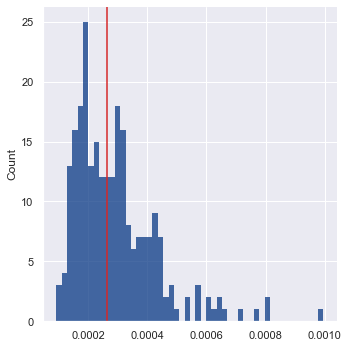

trial: 1


100%|██████████| 250/250 [00:17<00:00, 14.44it/s]


bandwidth: 0.5
p_value: 0.536
No image saved.


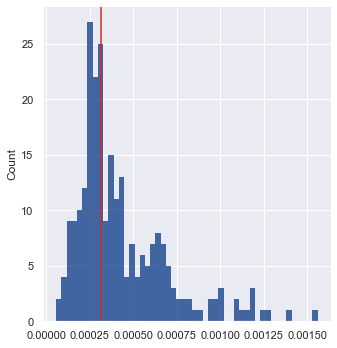

trial: 2


100%|██████████| 250/250 [00:17<00:00, 14.57it/s]


bandwidth: 0.5
p_value: 0.592
No image saved.


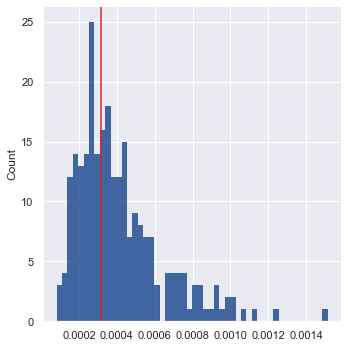

trial: 3


100%|██████████| 250/250 [00:18<00:00, 13.58it/s]


bandwidth: 0.5
p_value: 0.644
No image saved.


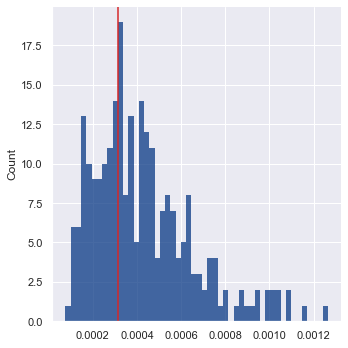

trial: 1


100%|██████████| 250/250 [00:18<00:00, 13.69it/s]


bandwidth: 1
p_value: 0.696
No image saved.


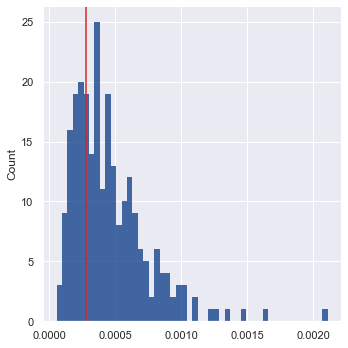

trial: 2


100%|██████████| 250/250 [00:16<00:00, 15.29it/s]


bandwidth: 1
p_value: 0.708
No image saved.


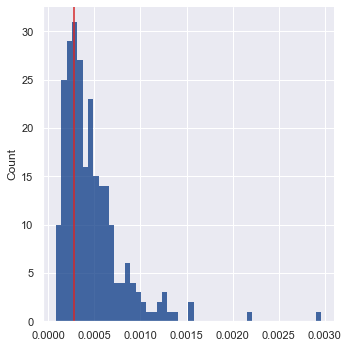

trial: 3


100%|██████████| 250/250 [00:16<00:00, 15.10it/s]


bandwidth: 1
p_value: 0.724
No image saved.


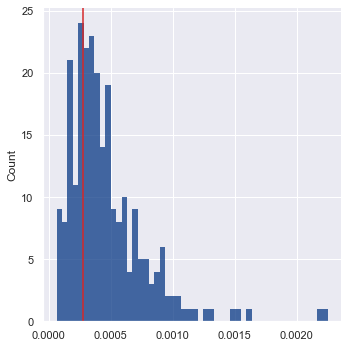

trial: 1


100%|██████████| 250/250 [00:16<00:00, 15.18it/s]


bandwidth: 2
p_value: 0.776
No image saved.


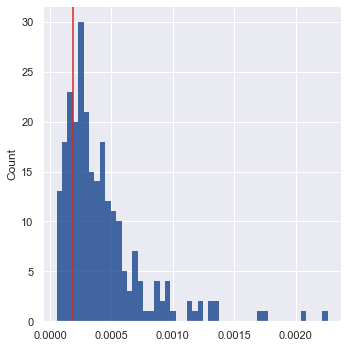

trial: 2


100%|██████████| 250/250 [00:16<00:00, 14.85it/s]


bandwidth: 2
p_value: 0.776
No image saved.


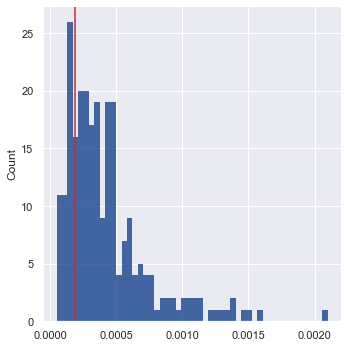

trial: 3


100%|██████████| 250/250 [00:18<00:00, 13.56it/s]


bandwidth: 2
p_value: 0.776
No image saved.


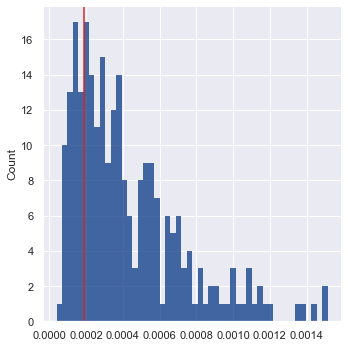

trial: 1


100%|██████████| 250/250 [00:17<00:00, 14.22it/s]


bandwidth: 4
p_value: 0.832
No image saved.


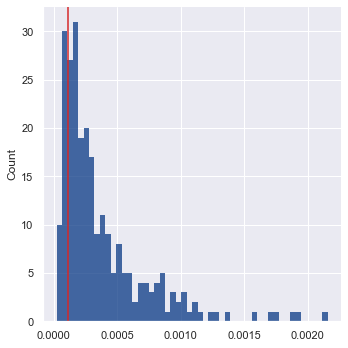

trial: 2


100%|██████████| 250/250 [00:16<00:00, 15.17it/s]


bandwidth: 4
p_value: 0.808
No image saved.


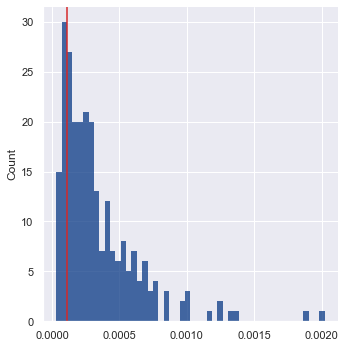

trial: 3


100%|██████████| 250/250 [00:16<00:00, 14.93it/s]


bandwidth: 4
p_value: 0.776
No image saved.


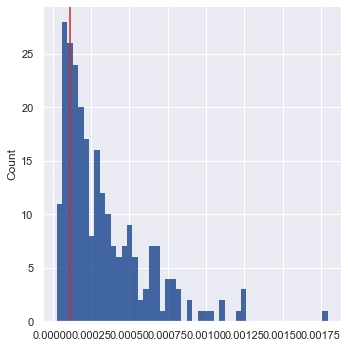

trial: 1


100%|██████████| 250/250 [00:17<00:00, 13.99it/s]


bandwidth: 8
p_value: 0.832
No image saved.


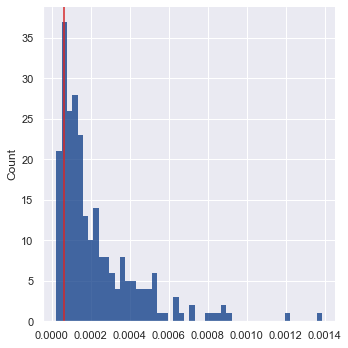

trial: 2


100%|██████████| 250/250 [00:18<00:00, 13.85it/s]

bandwidth: 8
p_value: 0.816
No image saved.


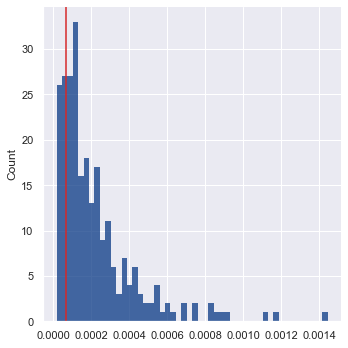

trial: 3


100%|██████████| 250/250 [00:16<00:00, 15.15it/s]


bandwidth: 8
p_value: 0.856
No image saved.


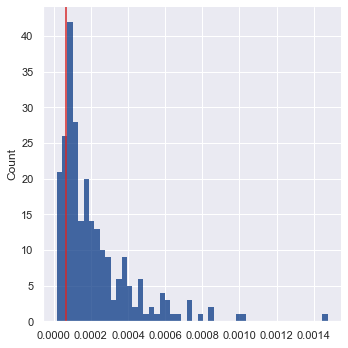

CPU times: user 10min 45s, sys: 22min 38s, total: 33min 24s
Wall time: 6min 56s


In [29]:
%%time

# anisotropic mmd
num_trials = 3
same_anisotropic_stats = {}
encoder.eval()
for val in [-3, -2, -1, 0, 1, 2, 3]:
    same_anisotropic_stats[val] = {}
    for trial in range(1, num_trials + 1):
        print('trial:', trial)
        start = time.time()
        observed_mmd_anisotropic5v5, simulated_mmds_anisotropic5v5 = permutation_test_anisotropic_mmd(
            x1_batch, x2_batch, r_batch, encoder, n_perms=n_perms, sigma_squared = (2 ** val)
        )
        end = time.time()
        p = p_val(simulated_mmds_anisotropic5v5, observed_mmd_anisotropic5v5)
        same_anisotropic_stats[val][trial] = {'p': p, 'time': end - start}

        hist_color = '#093885'
        line_color = 'tab:red'
        filepath = ''

        print('bandwidth:', str(np.round(2 ** val, 3)))
        plot_permutation(
            simulated_mmds_anisotropic5v5, 
            observed_mmd_anisotropic5v5, 
            hist_color = hist_color, 
            line_color = line_color,
            filepath = filepath
        )
        plt.show()

In [31]:
same_anisotropic_stats

{-3: {1: {'p': 0.328, 'time': 21.798611879348755},
  2: {'p': 0.328, 'time': 18.683148622512817},
  3: {'p': 0.328, 'time': 20.105113983154297}},
 -2: {1: {'p': 0.488, 'time': 19.129997730255127},
  2: {'p': 0.5, 'time': 19.986263036727905},
  3: {'p': 0.508, 'time': 23.152724027633667}},
 -1: {1: {'p': 0.536, 'time': 19.222920894622803},
  2: {'p': 0.592, 'time': 19.19744086265564},
  3: {'p': 0.644, 'time': 21.15546989440918}},
 0: {1: {'p': 0.696, 'time': 20.110068321228027},
  2: {'p': 0.708, 'time': 18.498719930648804},
  3: {'p': 0.724, 'time': 18.642405033111572}},
 1: {1: {'p': 0.776, 'time': 18.313293933868408},
  2: {'p': 0.776, 'time': 18.615455865859985},
  3: {'p': 0.776, 'time': 21.11746597290039}},
 2: {1: {'p': 0.832, 'time': 20.066126108169556},
  2: {'p': 0.808, 'time': 18.19675588607788},
  3: {'p': 0.776, 'time': 18.73832416534424}},
 3: {1: {'p': 0.832, 'time': 20.00403881072998},
  2: {'p': 0.816, 'time': 20.356895923614502},
  3: {'p': 0.856, 'time': 18.567101955

### Statistics for Encoder Kernel

100%|██████████| 250/250 [00:35<00:00,  6.99it/s]


bandwidth: 0.125
p_value: 0.528
No image saved.


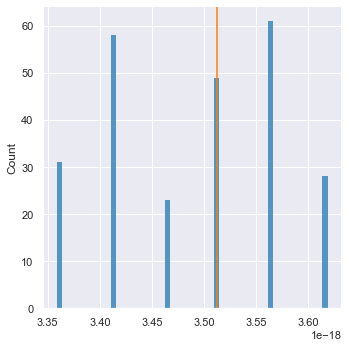

100%|██████████| 250/250 [00:32<00:00,  7.81it/s]


bandwidth: 0.125
p_value: 0.432
No image saved.


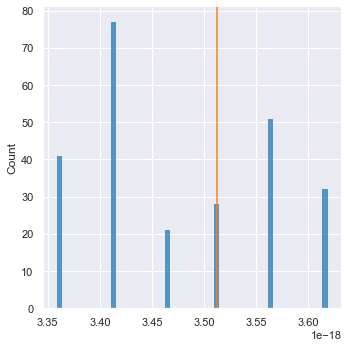

100%|██████████| 250/250 [00:36<00:00,  6.93it/s]


bandwidth: 0.125
p_value: 0.456
No image saved.


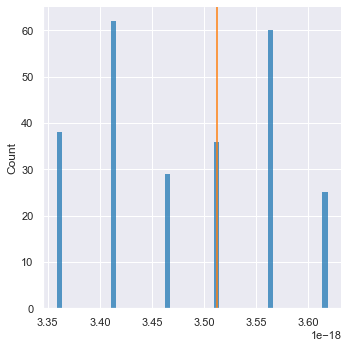

100%|██████████| 250/250 [00:30<00:00,  8.14it/s]


bandwidth: 0.25
p_value: 0.568
No image saved.


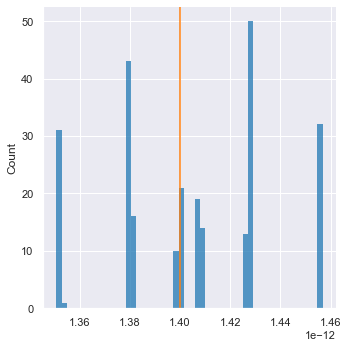

100%|██████████| 250/250 [00:30<00:00,  8.09it/s]


bandwidth: 0.25
p_value: 0.504
No image saved.


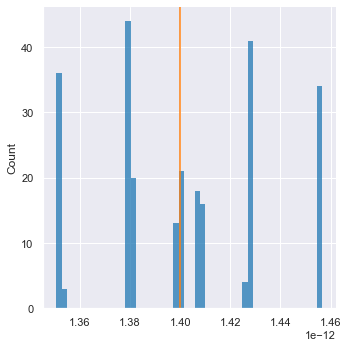

100%|██████████| 250/250 [00:35<00:00,  7.10it/s]


bandwidth: 0.25
p_value: 0.552
No image saved.


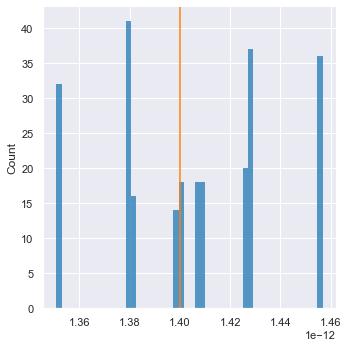

100%|██████████| 250/250 [00:31<00:00,  8.02it/s]


bandwidth: 0.5
p_value: 0.176
No image saved.


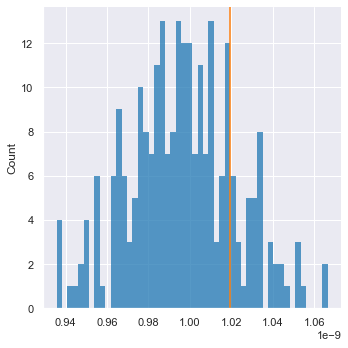

100%|██████████| 250/250 [00:31<00:00,  8.06it/s]


bandwidth: 0.5
p_value: 0.204
No image saved.


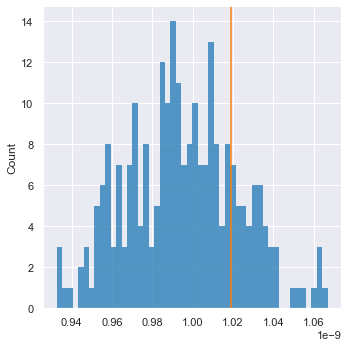

100%|██████████| 250/250 [00:32<00:00,  7.76it/s]


bandwidth: 0.5
p_value: 0.236
No image saved.


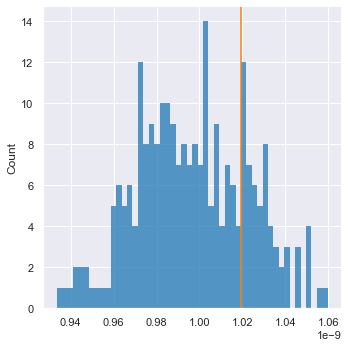

100%|██████████| 250/250 [00:30<00:00,  8.09it/s]


bandwidth: 1
p_value: 0.036
No image saved.


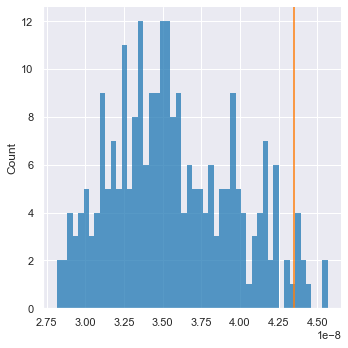

100%|██████████| 250/250 [00:35<00:00,  7.11it/s]


bandwidth: 1
p_value: 0.012
No image saved.


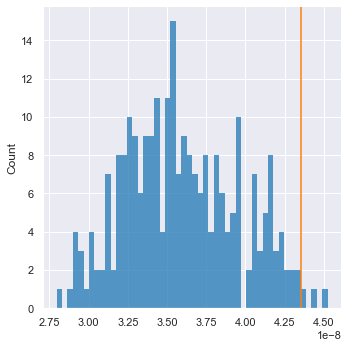

100%|██████████| 250/250 [00:32<00:00,  7.64it/s]


bandwidth: 1
p_value: 0.016
No image saved.


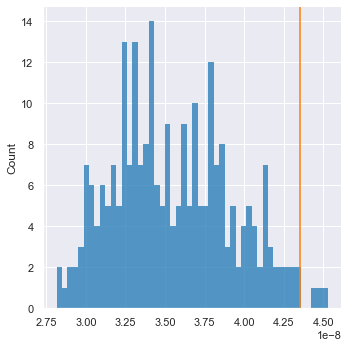

100%|██████████| 250/250 [00:31<00:00,  7.83it/s]


bandwidth: 2
p_value: 0.028
No image saved.


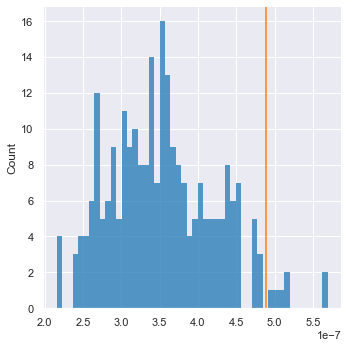

100%|██████████| 250/250 [00:31<00:00,  7.95it/s]


bandwidth: 2
p_value: 0.04
No image saved.


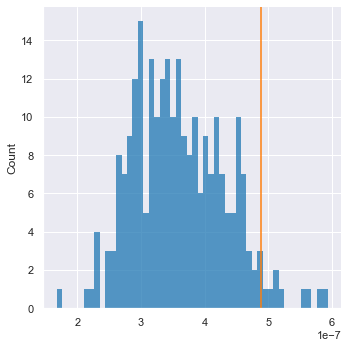

100%|██████████| 250/250 [00:34<00:00,  7.16it/s]


bandwidth: 2
p_value: 0.04
No image saved.


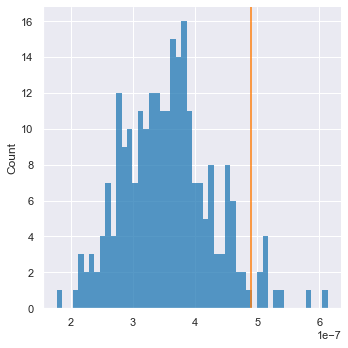

100%|██████████| 250/250 [00:31<00:00,  7.90it/s]


bandwidth: 4
p_value: 0.044
No image saved.


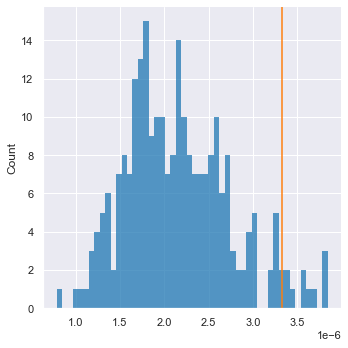

100%|██████████| 250/250 [00:31<00:00,  7.95it/s]


bandwidth: 4
p_value: 0.024
No image saved.


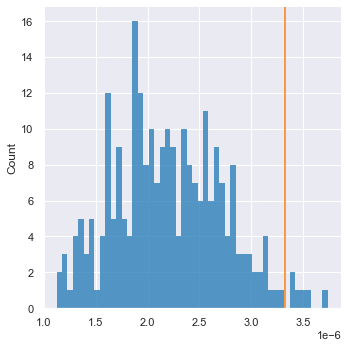

100%|██████████| 250/250 [00:31<00:00,  7.92it/s]


bandwidth: 4
p_value: 0.06
No image saved.


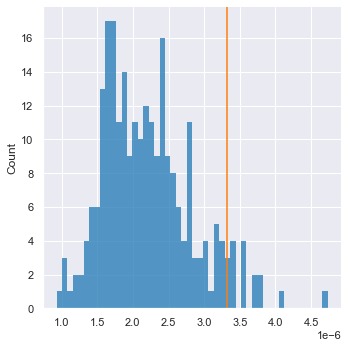

100%|██████████| 250/250 [00:31<00:00,  7.82it/s]


bandwidth: 8
p_value: 0.032
No image saved.


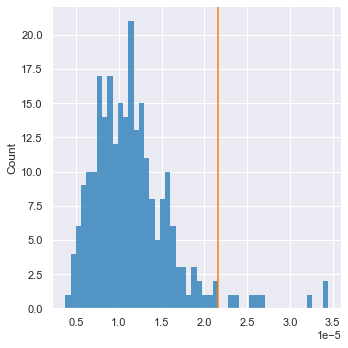

100%|██████████| 250/250 [00:32<00:00,  7.59it/s]


bandwidth: 8
p_value: 0.02
No image saved.


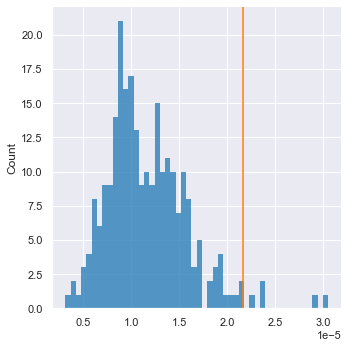

100%|██████████| 250/250 [00:31<00:00,  7.88it/s]


bandwidth: 8
p_value: 0.036
No image saved.


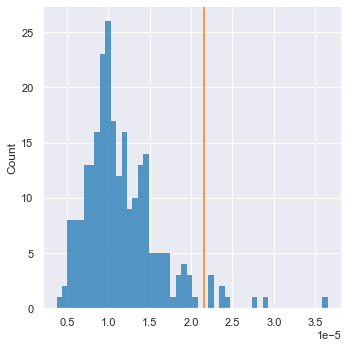

CPU times: user 14min 53s, sys: 39min 16s, total: 54min 9s
Wall time: 12min 54s


In [32]:
%%time

# encoder mmd
num_trials = 3
same_encoder_stats = {}
encoder.eval()
for val in [-3, -2, -1, 0, 1, 2, 3]:
    same_encoder_stats[val] = {}
    for trial in range(1, num_trials + 1):
        start = time.time()
        observed_mmd_encoder5v5, simulated_mmds_encoder5v5 = permutation_test_encoder_mmd(
            x1_batch, x2_batch, r_batch, encoder, n_perms=n_perms, sigma_squared=(2 ** val)
        )
        end = time.time()
        p = p_val(simulated_mmds_encoder5v5, observed_mmd_encoder5v5)
        same_encoder_stats[val][trial] = {'p': p, 'time': time}

        hist_color = 'tab:blue'
        line_color = 'tab:orange'
        filepath = ''

        print('bandwidth:', str(np.round(2 ** val, 3)))
        plot_permutation(
            simulated_mmds_encoder5v5, 
            observed_mmd_encoder5v5, 
            hist_color = hist_color, 
            line_color = line_color,
            filepath = filepath
        )
        plt.show()

In [33]:
same_encoder_stats

{-3: {1: {'p': 0.528, 'time': <module 'time' (built-in)>},
  2: {'p': 0.432, 'time': <module 'time' (built-in)>},
  3: {'p': 0.456, 'time': <module 'time' (built-in)>}},
 -2: {1: {'p': 0.568, 'time': <module 'time' (built-in)>},
  2: {'p': 0.504, 'time': <module 'time' (built-in)>},
  3: {'p': 0.552, 'time': <module 'time' (built-in)>}},
 -1: {1: {'p': 0.176, 'time': <module 'time' (built-in)>},
  2: {'p': 0.204, 'time': <module 'time' (built-in)>},
  3: {'p': 0.236, 'time': <module 'time' (built-in)>}},
 0: {1: {'p': 0.036, 'time': <module 'time' (built-in)>},
  2: {'p': 0.012, 'time': <module 'time' (built-in)>},
  3: {'p': 0.016, 'time': <module 'time' (built-in)>}},
 1: {1: {'p': 0.028, 'time': <module 'time' (built-in)>},
  2: {'p': 0.04, 'time': <module 'time' (built-in)>},
  3: {'p': 0.04, 'time': <module 'time' (built-in)>}},
 2: {1: {'p': 0.044, 'time': <module 'time' (built-in)>},
  2: {'p': 0.024, 'time': <module 'time' (built-in)>},
  3: {'p': 0.06, 'time': <module 'time' (